# **ML MODEL CREATION AND EVALUATION**

## Objectives

* Create a classification model that can distinguish healthy from infected leaves

## Inputs

* Prepared train, validation and test datasets
  - outputs/dataset/train_X.npy
  - outputs/dataset/train_y.npy
  - outputs/dataset/validation.npy
  - outputs/dataset/validation_y.npy
  - outputs/dataset/test_X.npy
  - outputs/dataset/test.npy

## Outputs

* Classification model
  - outputs/model/powdery_mildew_alerter_v?.keras

* Model evaluation performance
  - outputs/model/evaluation.csv

* Model summary and model training details images
  - outputs/model/loss_function_plot.png
  - outputs/model/accuracy_plot.png
  - outputs/model/model_summary.png

---

# Preparation for model fitting

## Change working directory

In [ ]:
import os

os.chdir("./..")  # change to parent directory
working_dir = os.getcwd()
working_dir  # check output for correct directory

## Load prepared data

In [ ]:
import numpy as np

output_dataset = working_dir + "/outputs/dataset"
train_X = np.load(output_dataset + "/train_X.npy")
train_y = np.load(output_dataset +"/train_y.npy")
validation_X = np.load(output_dataset + "/validation_X.npy")
validation_y = np.load(output_dataset +"/validation_y.npy")
test_X = np.load(output_dataset + "/test_X.npy")
test_y = np.load(output_dataset +"/test_y.npy")

## Pre-processing with encoder

In [ ]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

train_y_encoded = encoder.fit_transform(train_y)
validation_y_encoded = encoder.transform(validation_y)
test_y_encoded = encoder.transform(test_y)

---

# Model

## Model design
  - input layer
  - three convolution + max pooling layers
  - flatten layer
  - two dense layers with 35% dropout between them
  - output layer
  - adaptive moment estimation optimizer and binary crossentropy loss function as suggested by empirical performance

In [ ]:
from keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout 

def create_model():
    model = Sequential()

    #input layer
    model.add(Input(shape=(75, 75, 3)))

    # convolution + maxpool layer 1 - 32 filters
    model.add(
        Conv2D(
            filters=32,
            kernel_size=(3,3),
            activation="relu"
               )
    )
    model.add(MaxPooling2D(2, 2))

    # convolution + maxpool layer 2 - 64 filters
    model.add(
        Conv2D(
            filters=64,
            kernel_size=(3,3),
            activation="relu"
        )
    )
    model.add(MaxPooling2D(2, 2))

    # convolution + maxpool layer 3 - 128 filters
    model.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation="relu"
        )
    )
    model.add(MaxPooling2D(2, 2))

    # flatten layer
    model.add(Flatten())

    #two dense layers with 35% dropout
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.35))
    model.add(Dense(256, activation="relu"))

    # output layer
    model.add(Dense(1, activation="sigmoid"))

    #specify optimizer, loss function and metric
    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model

## Create the model

In [ ]:
powdery_mildew_alerter = create_model()

## Add early stopping logic

Saving best model is also added. Change "version" variable to not overwrite saved model(s)

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint 


save_dir = working_dir + "/outputs/model"
version = "v1"

if not "model" in os.listdir(working_dir + "/outputs"):
    os.makedirs(save_dir)

early_stop_val_loss_patience_4 = EarlyStopping(monitor="val_loss", patience=4)
select_best_model = ModelCheckpoint(
        f"{save_dir}/powdery_mildew_alerter_{version}.keras",
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    )

## Fit data / train model

In [ ]:
powdery_mildew_alerter.fit(
    train_X,
    train_y_encoded,
    epochs=25,
    verbose=1,
    validation_data=(validation_X, validation_y_encoded),
    callbacks=[early_stop_val_loss_patience_4, select_best_model]
    )

## Load best model

In [ ]:
from keras.models import load_model


best_model = load_model(f"{save_dir}/powdery_mildew_alerter_{version}.keras")

## Evaluate performance

Show structured evaluation performance and save to csv file

In [68]:
import pandas as pd

evaluation = best_model.evaluate(test_X, test_y_encoded, verbose=1)

eval_df = pd.DataFrame(
    {
        "Model metric": ["Loss function rate", "Accuracy"],
        "Performance (%)": [x * 100 for x in evaluation]
    }
)
eval_df.set_index("Model metric", inplace=True)

eval_df.to_csv(save_dir + "/evaluation.csv")
eval_df

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9977 - loss: 0.0647


,Performance (%)
Model metric,
Loss function rate,3.289106
Accuracy,99.881518


Model has a 100% accuracy on train/validation sets and 99.88% on test set

---

# Generate model training detail visuals

## Model summary

In [ ]:
powdery_mildew_alerter.summary()

## Learning curve

Plot and save loss function and accuracy graphs

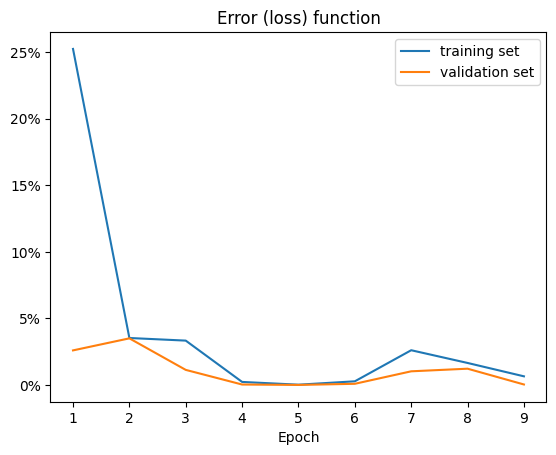

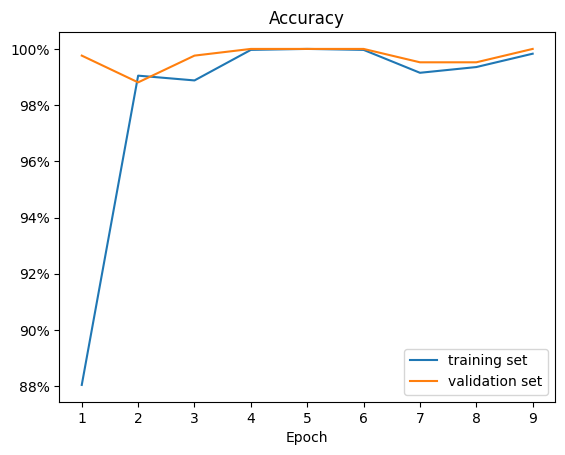

In [71]:
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import ticker


data = pd.DataFrame(powdery_mildew_alerter.history.history)
data.index += 1

data[["loss", "val_loss"]].plot()
plt.title("Error (loss) function")
plt.legend(labels=["training set", "validation set"])
plt.xlabel("Epoch")
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f"{int(x * 100)}%"))
plt.savefig(working_dir + "/outputs/images/loss_function_plot.png")
plt.show()

data[["accuracy", "val_accuracy"]].plot()
plt.title("Accuracy")
plt.legend(labels=["training set", "validation set"])
plt.xlabel("Epoch")
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f"{int(x * 100)}%"))
plt.savefig(working_dir + "/outputs/images/accuracy_plot.png")
plt.show()

---

# Create model predicting output functionality

Using function from "Data visualization" notebook for image resize and load into array. 

In [119]:
from keras.preprocessing import image


def load_resize_image_as_array(img_path, width, height):
    img = image.load_img(img_path, target_size=(width, height))
    return image.img_to_array(img) / 255


def model_prediction_for_image(img_path):
    img = load_resize_image_as_array(img_path, 75, 75)
    img = np.expand_dims(img, axis=0)
    return np.round(best_model.predict(img) * 100, 2)[0][0]


def model_prediction_to_text(img_path):
    result = model_prediction_for_image(img_path)

    text_for_display = "Leaf in this image "
    
    if result > 50:
        text_for_display += "contains powdery mildew"
    else:
        text_for_display += "is healthy"
        result = 100-result

    result_formatted = f"{result}".rstrip('0').rstrip('.')

    return text_for_display + f". Model is {result_formatted}% confident."

Test on random image. Image used here might not exist on your system.

In [121]:
# model_prediction_to_text(f"{working_dir}/inputs/dataset/cherry-leaves/test/healthy/2fcace57-26cb-485b-aff6-dbf4bae23ceb___JR_HL 9583.JPG")

# Next steps

With model that satisfies the requirement of at least 97% accuracy dashboard development can begin